In [1]:
import numpy as np
import itertools
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
with open('A.fna') as file:
    dataA = [line.rstrip() for line in file]
    
with open('B.fna') as file:
    dataB = [line.rstrip() for line in file]

The task is to differentiate which of the 2 files is real, and which is fake

Both datasets have 60 characters per line, have the same number of total characters, and there are ~16,000 lines.

As a starting point, I counted the number of occurrences for each character (A, C, G, T)

In [4]:
characters = ['A', 'C', 'G', 'T']

In [5]:
#returns the number of occurrences for a specific k-mer in a dataframe format
#k for k-mers (length of substring)
def kmer_counts(data, k):
       
    #generate the list of k-mers
    kmer_list = [''.join(i) for i in itertools.product(characters, repeat = k)]
    
    tostore_kmer_list = []
    
    #count the number of occurrences for a k-mer and store to list
    for kmer in kmer_list:
        count_kmers = 0
        for line in data:
            pair = [line[i:i+k] for i in range(0, len(line), k)]
            count_kmers += pair.count(kmer)
        tostore_kmer_list.append(count_kmers)
    
    return pd.DataFrame({'kmer':kmer_list, 'count_occurrences':tostore_kmer_list})

In [6]:
dfA = kmer_counts(dataA, 1)
dfA

,kmer,count_occurrences
0,A,239394
1,C,242288
2,G,259596
3,T,239855


In [7]:
dfB = kmer_counts(dataB, 1)
dfB

,kmer,count_occurrences
0,A,239394
1,C,242288
2,G,259596
3,T,239855


The number of occurrences for A, C, T, G are the same for both data A and data B. The next thing that I did was to count for the maximum length of consecutive characters for each line in the dataset. This is because there might be patterns from the real/fake data that can be found by counting the length of consecutive characters. As an example:

line 1: 'TGGTCCCACCTTTGAACCCC'\
line 2: 'TCAAATCAAGCGAAAGGCCA'

Then the function will output:\
line 1 has A: 2, C: 4, T: 3, G: 2\
line 2 has A: 3, C: 2, T: 3, G: 2

The next step that I did was to aggregate the results from the ~16000 lines by taking the mean, maximum count of consecutive characters, and the count of how many times it went above a certain threshold.

In [8]:
#returns the maximum count of consecutive characters for each line as shown in the example above
def max_count_consecutive_characters(data):
    list_letter = []
    for i in characters:
        list_ = []
        for line in data:
            try:
                max_count_per_line = max(len(list(y)) for (c,y) in itertools.groupby(line) if c==i)       
                list_.append(max_count_per_line)
            except:
                pass
        list_letter.append(list_)
    return list_letter

#returns statistics related to the maximum count of consecutive characters per data file
def display_count_statistics_of_characters(data):
    mean_list = []
    max_list = []
    greater_than_6 = []
    for i in range(len(characters)):
        list_letter = max_count_consecutive_characters(data)
        mean_list.append(np.mean(list_letter[i]))
        max_list.append(max(list_letter[i]))
        greater_than_6.append(sum(np.array(list_letter[i]) > 6))
    return pd.DataFrame({'characters':characters, 
                  'mean_max_consecutive_length': mean_list,
                  'max_consecutive_length_from_data': max_list, 
                  'count_consecutive_characters_longer_than_length6': greater_than_6})  

In [9]:
dfA_count = display_count_statistics_of_characters(dataA)
dfA_count

,characters,mean_max_consecutive_length,max_consecutive_length_from_data,count_consecutive_characters_longer_than_length6
0,A,2.940745,9,112
1,C,2.354492,8,1
2,G,2.498685,8,11
3,T,2.902587,10,123


In [10]:
dfB_count = display_count_statistics_of_characters(dataB)
dfB_count

,characters,mean_max_consecutive_length,max_consecutive_length_from_data,count_consecutive_characters_longer_than_length6
0,A,2.623555,9,38
1,C,2.649239,10,42
2,G,2.795878,10,65
3,T,2.643429,9,35


Aggregating the data collected for the count of maximum length of consecutive characters for each line in the dataset, it was found that the mean value and max_consecutive_length does not vary greatly between the two datasets. However, for the count of consecutive characters with length longer than 6, it was found that in contrast with data A, for data B, the occurrences of A, C, G, T does not vary greatly. This gives us a hint that data B may have been arranged randomly.

The next thing that I did was counting the number of occurrences for k-mers, with k = 2

Counting the number of occurences of 2-mers: 'AA', 'AC', 'CA', 'AG', 'GA', 'AT', 'TA', 'CC', 'CG', 'GC', 'CT', 'TC', 'GG', 'GT', 'TG', 'TT'

In [11]:
dfA = kmer_counts(dataA, 2)
dfA

,kmer,count_occurrences
0,AA,35471
1,AC,26700
2,AG,25561
3,AT,31940
4,CA,32587
5,CC,26675
6,CG,37476
7,CT,24511
8,GA,29470
9,GC,40796


In [12]:
dfB = kmer_counts(dataB, 2)
dfB

,kmer,count_occurrences
0,AA,29076
1,AC,29737
2,AG,31617
3,AT,29341
4,CA,29417
5,CC,29953
6,CG,31978
7,CT,29752
8,GA,31867
9,GC,32098


We can quantify for the entropy and see which has a higher entropy. A higher entropy means a higher disorder or randomness. 

In [13]:
def entropy(df):
    x = df['count_occurrences'].values
    p = x/sum(x)
    return -sum(p*np.log(p))

In [14]:
print('entropy of data A:', entropy(dfA))
print('entropy of data B:', entropy(dfB))

entropy of data A: 2.7588095393083387
entropy of data B: 2.7714405017649955


If the fake data was arranged completely random, we would expect that the real data has lesser entropy. Data B has a higher entropy, and so is the fake data. In a way this is in agreement that we have for the count of consecutive characters with length longer than 6 in the earlier result. 

The histogram plot for 2-mers is shown below:

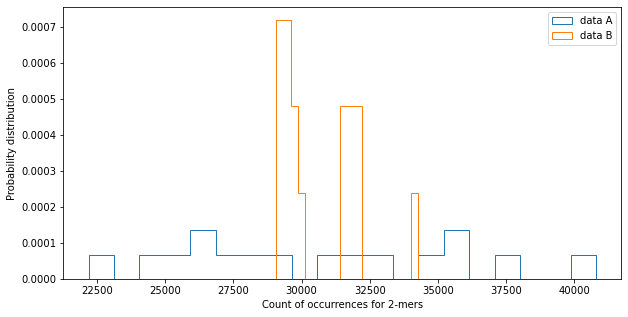

In [15]:
plt.figure(figsize=(10,5))
dfA['count_occurrences'].hist(histtype='step', bins = 20, density = True, label='data A')
dfB['count_occurrences'].hist(histtype='step', bins = 20, density = True, label='data B')
plt.xlabel('Count of occurrences for 2-mers')
plt.ylabel('Probability distribution')
plt.grid(b=None)
plt.legend()
plt.show()

It can be observed that the distribution for data B is peaked at certain values of count of occurrences, in contrast, data A is more uniformly distributed. This does not contradict with what was shown so far, this just tells us the relationship between 2-mers in the data. For data A, we can think that each 2-mer is independent with one another, having almost the same probability. 

This further shows that data B is the fake data since we would expect that the real dataset is uniformly distributed for k-mers.

The analysis can be extended for k-mers with k = 4, and see if the same result is obtained

In [16]:
dfA = kmer_counts(dataA, 4)
dfA.head()

,kmer,count_occurrences
0,AAAA,1850
1,AAAC,1284
2,AAAG,1196
3,AAAT,1321
4,AACA,1094


In [17]:
dfB = kmer_counts(dataB, 4)
dfB.head()

,kmer,count_occurrences
0,AAAA,855
1,AAAC,898
2,AAAG,972
3,AAAT,880
4,AACA,921


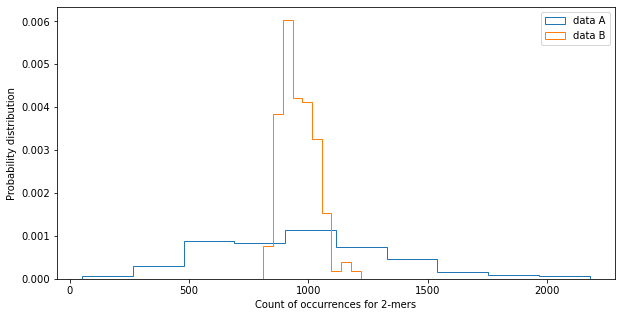

In [18]:
plt.figure(figsize=(10,5))
dfA['count_occurrences'].hist(histtype='step', density = True, label='data A')
dfB['count_occurrences'].hist(histtype='step', density = True, label='data B')
plt.xlabel('Count of occurrences for 2-mers')
plt.ylabel('Probability distribution')
plt.grid(b=None)
plt.legend()
plt.show()

In [19]:
print('entropy of data A:', entropy(dfA))
print('entropy of data B:', entropy(dfB))

entropy of data A: 5.467764524586647
entropy of data B: 5.542373745682105


For 4-mers, the histogram plot shows data B peaked at certain values, and data B having higher entropy, which is in agreement with the results that were shown for 2-mers. This indicates that data B is indeed the fake data.

The last thing that I did was to divide each dataset into 3 groups, and counting for the number of occurences for 2-mers for each group.

In [20]:
#similar with kmer_counts function but performing it in each subgroup of the dataset
def kmer_occurrences_groups(data, k):
    kmer_list = [''.join(i) for i in itertools.product(characters, repeat = k)]
    
    tostore_kmer_list = []

    groups = [data[i:i+5451] for i in range(0, len(data), 5451)]
    for g in groups:
        groups_list = []
        for kmer in kmer_list:
            count_kmers = 0
            for line in g:
                pair = [line[i:i+k] for i in range(0, len(line), k)]
                count_kmers += pair.count(kmer)
            groups_list.append(count_kmers)
        tostore_kmer_list.append(groups_list)

    return pd.DataFrame({'kmer':kmer_list,
                         'count_occurrences_g1':tostore_kmer_list[0],
                         'count_occurrences_g2':tostore_kmer_list[1],
                         'count_occurrences_g3':tostore_kmer_list[2], })

In [21]:
#k-mer with k = 2
dfA_groups = kmer_occurrences_groups(dataA, 2)
dfB_groups = kmer_occurrences_groups(dataB, 2)

In [22]:
dfA_groups.head()

,kmer,count_occurrences_g1,count_occurrences_g2,count_occurrences_g3
0,AA,11583,12149,11739
1,AC,8720,8777,9203
2,AG,8577,8485,8499
3,AT,10604,10993,10343
4,CA,10683,10679,11225


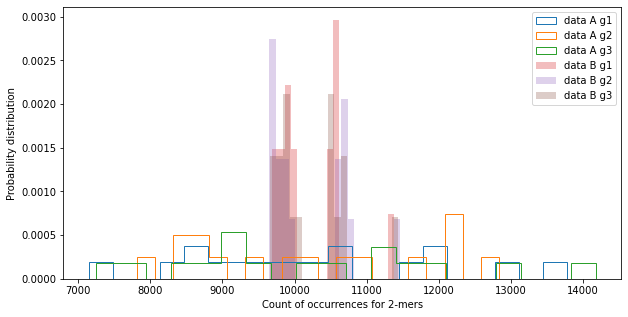

In [23]:
plt.figure(figsize=(10,5))
dfA_groups['count_occurrences_g1'].hist(histtype='step', density = True, bins = 20, label='data A g1')
dfA_groups['count_occurrences_g2'].hist(histtype='step', density = True, bins = 20, label='data A g2')
dfA_groups['count_occurrences_g3'].hist(histtype='step', density = True, bins = 20, label='data A g3')

dfB_groups['count_occurrences_g1'].hist(histtype='stepfilled', density = True, bins = 20, label='data B g1', alpha = 0.3)
dfB_groups['count_occurrences_g2'].hist(histtype='stepfilled', density = True, bins = 20, label='data B g2', alpha = 0.3)
dfB_groups['count_occurrences_g3'].hist(histtype='stepfilled', density = True, bins = 20, label='data B g3', alpha = 0.3)
plt.xlabel('Count of occurrences for 2-mers')
plt.ylabel('Probability distribution')
plt.grid(b=None)
plt.legend()
plt.show()

Even having divided it into 3 groups, the histogram plot shows data B peaked at certain values.